In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import scale

In [2]:
harp_flare_data = pd.read_parquet("../combined_data/harp_flare_data.parquet")
harp_flare_data.head()

,HARPNUM,T_REC,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,...,T_FRST1,T_LAST1,NOAA_AR,NOAA_NUM,NOAA_ARS,start time,peak time,end time,flare_class,peak_intensity
0,1,2010-05-01 00:00:00+00:00,6.510776e+21,28.337,66.808,84.497,32.193,-0.131873,5.777592e+12,0.009330,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
1,1,2010-05-01 00:12:00+00:00,6.521054e+21,29.678,68.349,90.781,32.345,-0.113589,5.654726e+12,-0.004021,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
2,1,2010-05-01 00:24:00+00:00,6.917875e+21,28.441,67.682,89.127,32.411,0.061197,6.488687e+12,0.003400,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
3,1,2010-05-01 00:36:00+00:00,6.973706e+21,28.031,67.166,85.321,31.966,0.053302,6.193157e+12,0.005150,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN
4,1,2010-05-01 00:48:00+00:00,7.228647e+21,26.980,64.805,76.349,32.647,0.011571,5.797055e+12,0.000902,...,2010-05-01 00:00:00+00:00,2010-05-11 16:12:00+00:00,11067,1,11067,NaT,NaT,NaT,<NA>,NaN


In [3]:
sharp_params = [
    "USFLUX", "MEANGAM", "MEANGBT", "MEANGBZ", "MEANGBH", "MEANJZD", "TOTUSJZ", "MEANALP",
    "MEANJZH", "TOTUSJH", "ABSNJZH", "SAVNCPP", "MEANPOT", "TOTPOT", "MEANSHR", "SHRGT45"
]
areas_counts = ["NPIX", "SIZE", "AREA", "NACR", "SIZE_ACR", "AREA_ACR"] # Patch areas and pixel counts
all_predictors = sharp_params + areas_counts

In [4]:
harp_flare_data["are_any_sharp_params_na"] = harp_flare_data[sharp_params].isna().any(axis=1)
harp_flare_data["are_any_areas_counts_na"] = harp_flare_data[areas_counts].isna().any(axis=1)
harp_flare_data["are_any_predictors_na"] = harp_flare_data[all_predictors].isna().any(axis=1)
harp_flare_data["was_during_flare"] = ~harp_flare_data["flare_class"].isna()
harp_flare_data["was_during_c_plus_flare"] = harp_flare_data["flare_class"].isin(["C", "M", "X"])
harp_flare_data["was_during_m_plus_flare"] = harp_flare_data["flare_class"].isin(["M", "X"])

In [5]:
harp_flare_data[["are_any_sharp_params_na", "was_during_flare"]].value_counts()

are_any_sharp_params_na  was_during_flare
False                    False               4097741
True                     False                414979
False                    True                  39536
True                     True                    387
Name: count, dtype: int64

In [7]:
harp_flare_data[["are_any_sharp_params_na", "was_during_c_plus_flare"]].value_counts()

are_any_sharp_params_na  was_during_c_plus_flare
False                    False                      4107326
True                     False                       415074
False                    True                         29951
True                     True                           292
Name: count, dtype: int64

In [8]:
harp_flare_data[["are_any_sharp_params_na", "was_during_m_plus_flare"]].value_counts()

are_any_sharp_params_na  was_during_m_plus_flare
False                    False                      4133021
True                     False                       415332
False                    True                          4256
True                     True                            34
Name: count, dtype: int64

In [9]:
def run_graphical_lasso(
        harp_data: pd.DataFrame,
        cols: list[str],
        alphas=4,
        n_refinements=4,
        cv=None,
        tol=0.0001,
        enet_tol=0.0001,
        max_iter=100,
        mode="cd",
        n_jobs=None,
        verbose=False,
        eps=np.float64(2.220446049250313e-16),
        return_partial_cors=False
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    scale(harp_data, copy=False)
    model = GraphicalLassoCV(
        alphas=alphas,
        n_refinements=n_refinements,
        cv=cv,
        tol=tol,
        enet_tol=enet_tol,
        max_iter=max_iter,
        mode=mode,
        n_jobs=n_jobs,
        verbose=verbose,
        eps=eps,
        assume_centered=True
    )
    model.fit(harp_data)

    precision_mat = model.precision_
    # See the following for information on partial correlations:
    # https://en.wikipedia.org/wiki/Partial_correlation#Using_matrix_inversion
    # https://stats.stackexchange.com/a/310935/58497
    if return_partial_cors:
        sqrt_diag = np.sqrt(np.diagonal(precision_mat))
        precision_mat = precision_mat / sqrt_diag[np.newaxis, :]
        precision_mat = precision_mat / sqrt_diag[:, np.newaxis]
        precision_mat = -precision_mat
    precision_mat = pd.DataFrame(precision_mat).rename(columns={i: col for i, col in enumerate(cols)})
    precision_mat.index = cols

    costs = pd.DataFrame(model.costs_).rename(columns={0: "obj_fun_val", 1: "dual_gap"}).reset_index(names="iter_num")
    alpha = model.alpha_
    cv_results = model.cv_results_

    return precision_mat, costs, alpha, cv_results

def plot_precision_mat(precision_mat: pd.DataFrame, fix_precision_lims=False) -> ggplot:
    precision_mat_long = precision_mat.reset_index(names="var1").melt(id_vars="var1", var_name="var2", value_name="precision")
    limits = (-1, 1) if fix_precision_lims else None
    plot = (
        ggplot(precision_mat_long, aes(x="var1", y="var2", fill="precision")) +
        geom_tile() +
        scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0, limits=limits) +
        labs(x="Variable 1", y="Variable 2", fill="Precision") +
        theme_bw() +
        theme(axis_text_x=element_text(rotation=45))
    )
    return plot

def plot_costs(costs: pd.DataFrame) -> ggplot:
    costs_long = pd.melt(costs, id_vars="iter_num", value_vars=["obj_fun_val", "dual_gap"], var_name="var", value_name="val")
    plot = (
        ggplot(data=costs_long, mapping=aes(x="iter_num", y="val")) +
        facet_wrap(
            facets="var",
            scales="free_y",
            labeller=as_labeller({"obj_fun_val": "Objective Function Value", "dual_gap": "Dual Gap"})
        ) +
        geom_line() +
        labs(x = "Iteration Number", y="") +
        theme_bw()
    )
    return plot

In [21]:
sharp_params_a_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & harp_flare_data["was_during_flare"], sharp_params],
    sharp_params,
    return_partial_cors=True
)
sharp_params_a_plus_precision_mat_plot = plot_precision_mat(
    sharp_params_a_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All A+ HARP Records")

sharp_params_c_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & harp_flare_data["was_during_c_plus_flare"], sharp_params],
    sharp_params,
    return_partial_cors=True
)
sharp_params_c_plus_precision_mat_plot = plot_precision_mat(
    sharp_params_c_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All C+ HARP Records")

sharp_params_m_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & harp_flare_data["was_during_m_plus_flare"], sharp_params],
    sharp_params,
    return_partial_cors=True
)
sharp_params_m_plus_precision_mat_plot = plot_precision_mat(
    sharp_params_m_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All M+ HARP Records")

sharp_params_no_flare_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_sharp_params_na"] & ~harp_flare_data["was_during_flare"], sharp_params],
    sharp_params,
    return_partial_cors=True
)
sharp_params_no_flare_precision_mat_plot = plot_precision_mat(
    sharp_params_no_flare_precision_mat, fix_precision_lims=True
) + ggtitle("All Non-Flare HARP Records")

save_as_pdf_pages(
    [
        sharp_params_a_plus_precision_mat_plot, sharp_params_c_plus_precision_mat_plot, sharp_params_m_plus_precision_mat_plot,
        sharp_params_no_flare_precision_mat_plot
    ],
    filename="sharp_params_precision_mat_plots.pdf"
)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_dat

In [22]:
all_predictors_a_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_predictors_na"] & harp_flare_data["was_during_flare"], all_predictors],
    all_predictors,
    return_partial_cors=True
)
all_predictors_a_plus_precision_mat_plot = plot_precision_mat(
    all_predictors_a_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All A+ HARP Records")

all_predictors_c_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_predictors_na"] & harp_flare_data["was_during_c_plus_flare"], all_predictors],
    all_predictors,
    return_partial_cors=True
)
all_predictors_c_plus_precision_mat_plot = plot_precision_mat(
    all_predictors_c_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All C+ HARP Records")

all_predictors_m_plus_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_predictors_na"] & harp_flare_data["was_during_m_plus_flare"], all_predictors],
    all_predictors,
    return_partial_cors=True
)
all_predictors_m_plus_precision_mat_plot = plot_precision_mat(
    all_predictors_m_plus_precision_mat, fix_precision_lims=True
) + ggtitle("All M+ HARP Records")

all_predictors_no_flare_precision_mat, _, _, _ = run_graphical_lasso(
    harp_flare_data.loc[~harp_flare_data["are_any_predictors_na"] & ~harp_flare_data["was_during_flare"], all_predictors],
    all_predictors,
    return_partial_cors=True
)
all_predictors_no_flare_precision_mat_plot = plot_precision_mat(
    all_predictors_no_flare_precision_mat, fix_precision_lims=True
) + ggtitle("All Non-Flare HARP Records")

save_as_pdf_pages(
    [
        all_predictors_a_plus_precision_mat_plot, all_predictors_c_plus_precision_mat_plot, all_predictors_m_plus_precision_mat_plot,
        all_predictors_no_flare_precision_mat_plot
    ],
    filename="all_predictors_precision_mat_plots.pdf"
)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.018e-04
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/l

In [24]:
harp_stats = harp_flare_data.groupby("HARPNUM").size().reset_index(name="num_recs")

are_any_sharp_params_na = harp_flare_data[sharp_params].isna().any(axis=1)
harp_stats["sharp_params_na_prop"] = are_any_sharp_params_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

are_any_areas_counts_na = harp_flare_data[areas_counts].isna().any(axis=1)
harp_stats["areas_counts_na_prop"] = are_any_areas_counts_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

are_any_predictors_na = harp_flare_data[all_predictors].isna().any(axis=1)
harp_stats["all_predictors_na_prop"] = are_any_predictors_na.groupby(harp_flare_data["HARPNUM"]).mean().reset_index(drop=True)

was_during_flare = ~harp_flare_data["flare_class"].isna()
harp_stats["num_flare_recs"] = was_during_flare.groupby(harp_flare_data["HARPNUM"]).sum().reset_index(drop=True)
harp_stats["num_c_plus_recs"] = was_during_c_plus_flare.groupby(harp_flare_data["HARPNUM"]).sum().reset_index(drop=True)
harp_stats["num_m_plus_recs"] = was_during_m_plus_flare.groupby(harp_flare_data["HARPNUM"]).sum().reset_index(drop=True)

harp_stats.head()

,HARPNUM,num_recs,sharp_params_na_prop,areas_counts_na_prop,all_predictors_na_prop,num_flare_recs
0,1,1282,0.028861,0.027301,0.028861,5
1,2,541,0.070240,0.070240,0.070240,1
2,5,267,0.123596,0.123596,0.123596,5
3,6,524,0.047710,0.047710,0.047710,0
4,8,733,0.006821,0.006821,0.006821,26


In [22]:
harp_stats

,HARPNUM,num_recs,sharp_params_na_prop,areas_counts_na_prop,predictors_na_prop,num_flare_recs
0,1,1282,0.028861,0.027301,0.028861,5
1,2,541,0.070240,0.070240,0.070240,1
2,5,267,0.123596,0.123596,0.123596,5
3,6,524,0.047710,0.047710,0.047710,0
4,8,733,0.006821,0.006821,0.006821,26
...,...,...,...,...,...,...
6456,11564,182,0.615385,0.609890,0.615385,0
6457,11568,26,0.000000,0.000000,0.000000,0
6458,11569,344,0.122093,0.122093,0.122093,0
6459,11570,20,0.050000,0.050000,0.050000,0


In [25]:
has_no_nas = np.isclose(harp_stats["sharp_params_na_prop"], 0)
has_enough_recs = harp_stats["num_recs"] >= 200
harp_stats[has_no_nas & has_enough_recs]

,HARPNUM,num_recs,sharp_params_na_prop,areas_counts_na_prop,predictors_na_prop,num_flare_recs
28,44,244,0.0,0.0,0.0,1
44,68,278,0.0,0.0,0.0,4
178,317,598,0.0,0.0,0.0,0
190,335,901,0.0,0.0,0.0,0
193,340,243,0.0,0.0,0.0,0
208,361,688,0.0,0.0,0.0,12
326,589,535,0.0,0.0,0.0,0
374,662,1048,0.0,0.0,0.0,1
387,677,265,0.0,0.0,0.0,0
390,681,822,0.0,0.0,0.0,1


In [ ]:
harp_num = 317
cols = sharp_params
harp_data = harp_flare_data.loc[harp_flare_data["HARPNUM"] == harp_num, cols]
precision_mat, costs, _, _ = run_graphical_lasso(harp_data, cols, return_partial_cors=True)

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.227e-03


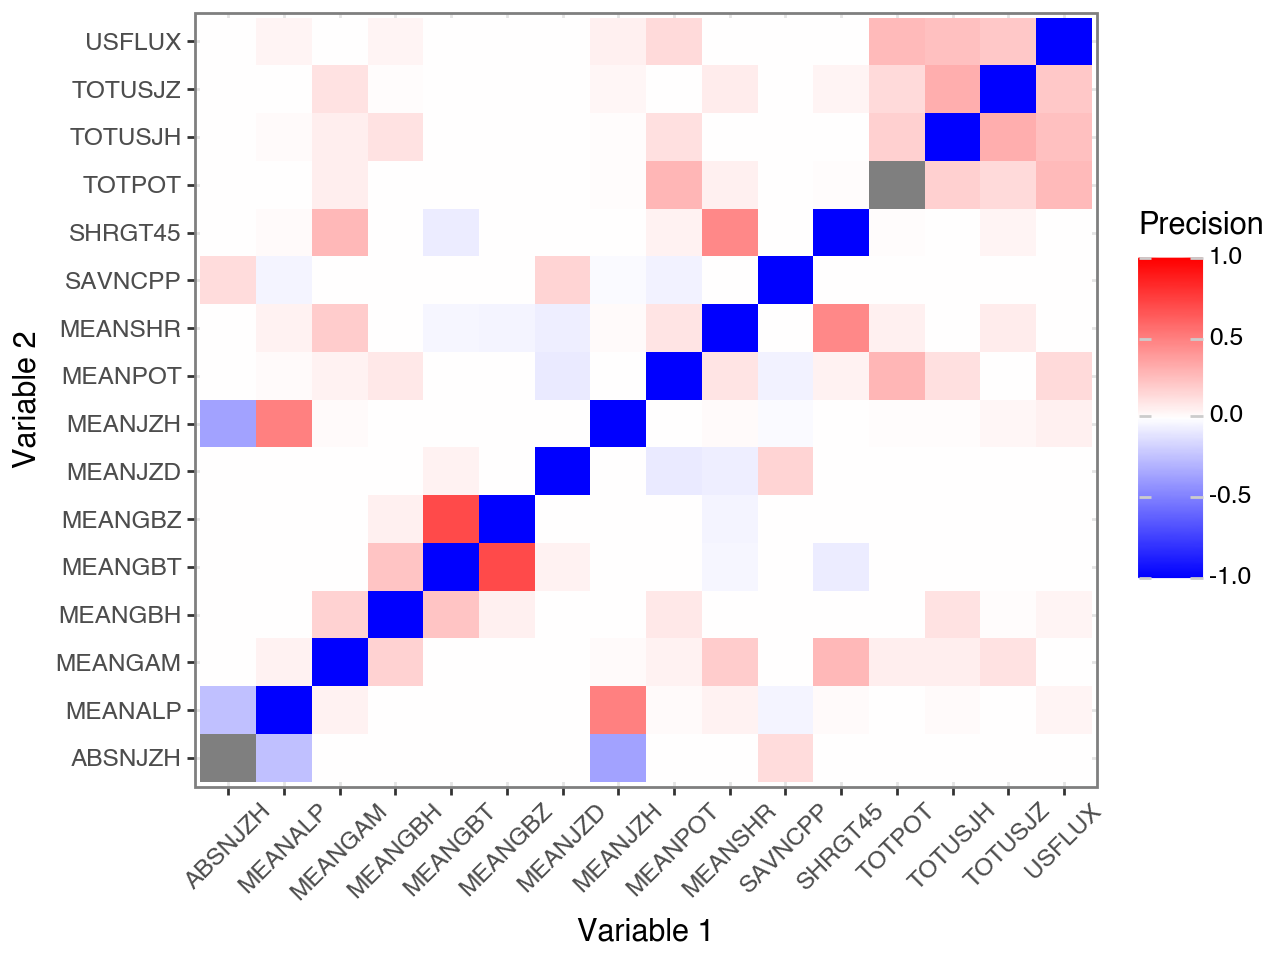

In [35]:
plot_precision_mat(precision_mat, fix_precision_lims=True)

In [26]:
flare_data = pd.read_parquet("../flare_data/flare_data.parquet")
flare_data.head()

,start time,end time,peak time,flare_class,peak_intensity,noaa_ar_5min,noaa_ar_5s,hg1,hg2,car1,car2,rtheta1,rtheta2,xy1,xy2,solar_p_angle,solar_radius
0,2010-01-01 06:02:00+00:00,2010-01-01 06:13:00+00:00,2010-01-01 06:09:00+00:00,B,1.100000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-01 12:00:00+00:00,2010-01-01 12:19:00+00:00,2010-01-01 12:09:00+00:00,B,2.700000e-07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-01 12:27:00+00:00,2010-01-01 13:09:00+00:00,2010-01-01 12:43:00+00:00,B,3.300000e-07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-01 15:58:00+00:00,2010-01-01 16:31:00+00:00,2010-01-01 16:20:00+00:00,B,2.500000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-01 18:20:00+00:00,2010-01-01 18:31:00+00:00,2010-01-01 18:27:00+00:00,B,1.300000e-07,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
flare_data[flare_data["flare_class"] == "X"].head()

,start time,end time,peak time,flare_class,peak_intensity,noaa_ar_5min,noaa_ar_5s,hg1,hg2,car1,car2,rtheta1,rtheta2,xy1,xy2,solar_p_angle,solar_radius
399,2010-02-12 11:15:00+00:00,2010-02-12 11:30:00+00:00,2010-02-12 11:26:00+00:00,X,0.00012,11046,11046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2538,2011-02-15 01:44:00+00:00,2011-02-15 02:07:00+00:00,2011-02-15 01:56:00+00:00,X,0.00033,11158,11158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3626,2011-07-30 02:04:00+00:00,2011-07-30 02:13:00+00:00,2011-07-30 02:09:00+00:00,X,0.00013,11261,11261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3705,2011-08-04 03:36:00+00:00,2011-08-04 04:05:00+00:00,2011-08-04 03:57:00+00:00,X,0.00013,11261,11261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3793,2011-08-09 07:44:00+00:00,2011-08-09 08:09:00+00:00,2011-08-09 08:04:00+00:00,X,0.00100,11263,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


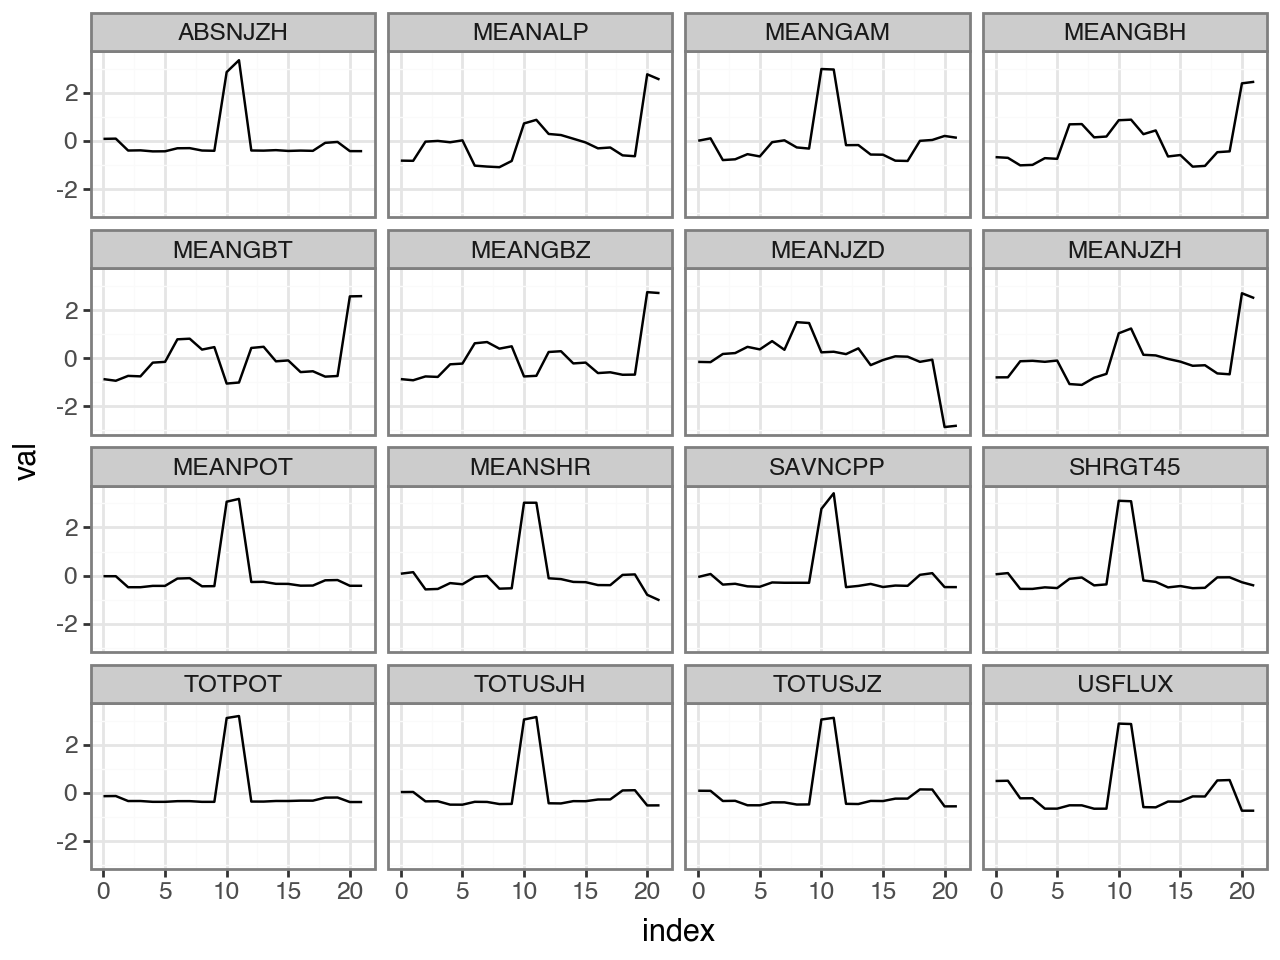

In [61]:
i = 2538
start_time = flare_data.loc[i, "start time"]
end_time = flare_data.loc[i, "end time"]
block = harp_flare_data.loc[(harp_flare_data["T_REC"] >= start_time) & (harp_flare_data["T_REC"] <= end_time), ["T_REC"] + sharp_params + ["start time", "end time", "flare_class", "peak_intensity"]]
# block

block2 = pd.DataFrame(scale(block[sharp_params]))
block2.columns = sharp_params
block2.reset_index(inplace=True)

block_long = pd.melt(
    block2,#block2[["T_REC"] + sharp_params],
    id_vars="index",#"T_REC",
    value_vars=sharp_params,
    var_name="var",
    value_name="val"
)

(
    ggplot(data=block_long, mapping=aes(x="index", y="val")) +
    facet_wrap(facets="var") +
    geom_line() +
    theme_bw()
)

In [66]:
flare_data[flare_data["flare_class"] == "B"].tail()

,start time,end time,peak time,flare_class,peak_intensity,noaa_ar_5min,noaa_ar_5s,hg1,hg2,car1,car2,rtheta1,rtheta2,xy1,xy2,solar_p_angle,solar_radius
30183,2024-04-09 18:27:00+00:00,2024-04-09 18:39:00+00:00,2024-04-09 18:34:00+00:00,B,7.600000e-07,13634,13634,322.40024,27.844042,315.31696,27.844042,0.763893,45.103153,-518.13495,516.271060,-26.219147,957.51263
30185,2024-04-09 23:32:00+00:00,2024-04-09 23:47:00+00:00,2024-04-09 23:41:00+00:00,B,9.400000e-07,13629,13629,-9999.00000,-9999.000000,-9999.00000,-9999.000000,1.072227,278.315900,1015.81580,148.478640,-26.213633,957.45490
30187,2024-04-10 02:42:00+00:00,2024-04-10 02:49:00+00:00,2024-04-10 02:45:00+00:00,B,7.600000e-07,0,0,-9999.00000,-9999.000000,-9999.00000,-9999.000000,1.102237,275.580660,1050.30360,102.624565,-26.210245,957.42035
30191,2024-04-10 08:33:00+00:00,NaT,2024-04-10 08:42:00+00:00,B,8.100000e-07,0,0,324.37440,22.482540,309.51816,22.482540,0.709106,49.596750,-516.95650,440.013950,-26.203428,957.35345
30192,2024-04-10 08:50:00+00:00,2024-04-10 08:58:00+00:00,2024-04-10 08:54:00+00:00,B,7.300000e-07,0,0,356.49054,-1.836708,341.52432,-1.836708,0.094465,40.592520,-58.84417,68.672810,-26.203190,957.35120


                            T_REC        USFLUX  MEANGAM  MEANGBT  MEANGBZ  \
4383496 2024-04-09 18:36:00+00:00  2.333809e+21   22.528   89.701   88.934   
4385203 2024-04-09 18:36:00+00:00  4.809699e+21   24.036  110.705  109.838   
4386971 2024-04-09 18:36:00+00:00  3.204797e+21   27.052  120.175  118.080   
4388403 2024-04-09 18:36:00+00:00  6.364252e+21   28.347   71.682   89.120   
4389379 2024-04-09 18:36:00+00:00  2.689794e+21   30.723  124.361  122.699   
4390736 2024-04-09 18:36:00+00:00  1.129268e+22   60.227   74.248   80.917   
4392385 2024-04-09 18:36:00+00:00  3.055765e+21   28.019  119.376  117.449   
4393240 2024-04-09 18:36:00+00:00  1.133205e+22   45.608  103.954  103.923   
4394894 2024-04-09 18:36:00+00:00  2.323442e+20   29.238  144.757  142.729   
4395311 2024-04-09 18:36:00+00:00  7.493733e+21   25.901  117.067  116.323   
4396643 2024-04-09 18:36:00+00:00  8.577295e+21   27.521   99.418  100.057   
4398122 2024-04-09 18:36:00+00:00  3.129538e+21   28.270  121.13

/Users/vkverma/research/xray_flux_forecasting/env/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.


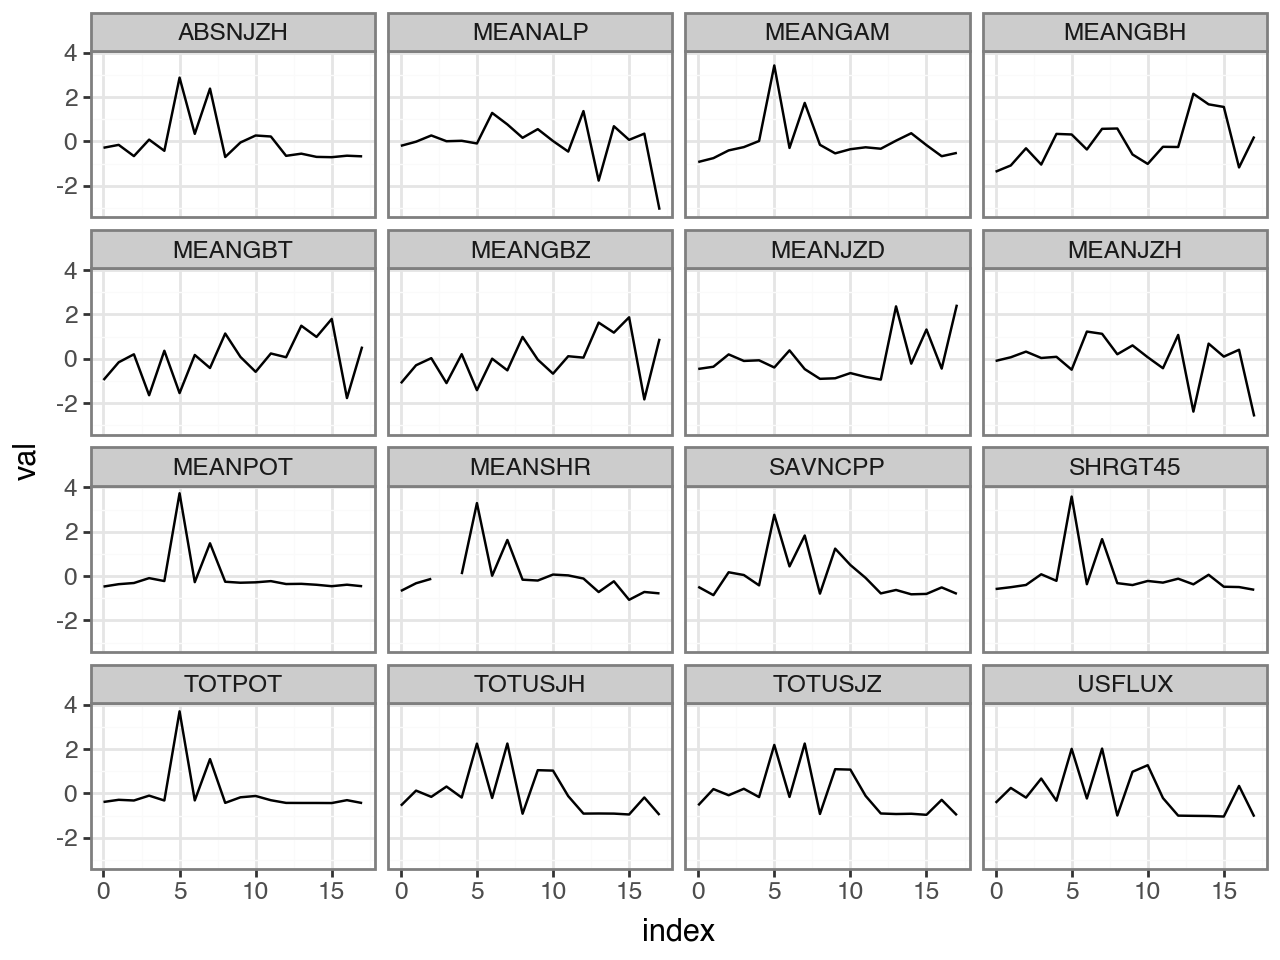

In [69]:
i = 30183
start_time = flare_data.loc[i, "start time"]
end_time = flare_data.loc[i, "end time"]
block = harp_flare_data.loc[(harp_flare_data["T_REC"] >= start_time) & (harp_flare_data["T_REC"] <= end_time), ["T_REC"] + sharp_params + ["start time", "end time", "flare_class", "peak_intensity"]]


block2 = pd.DataFrame(scale(block[sharp_params]))
block2.columns = sharp_params
block2.reset_index(inplace=True)

block_long = pd.melt(
    block2,#block2[["T_REC"] + sharp_params],
    id_vars="index",#"T_REC",
    value_vars=sharp_params,
    var_name="var",
    value_name="val"
)

(
    ggplot(data=block_long, mapping=aes(x="index", y="val")) +
    facet_wrap(facets="var") +
    geom_line() +
    theme_bw()
)